### Oxygen maps
### 2023
### Lena Viktorsson & Martin Hansson
### Copy from Karin Wesslander

#### Add necessary packages

In [1]:
#import Pkg
#Pkg.add("Pkg")
#Pkg.update("NCDatasets")
#import Pkg; 
#Pkg.add("DataStructures")
#Pkg.add("Missings")
#@show NCDatasets("version")

In [2]:
using DIVAnd
using PyPlot
using NCDatasets
using Dates
using Statistics
using DelimitedFiles
using DataStructures
using Printf
using Missings

## Configuration
* Define the horizontal, vertical and temporal resolutions.
* Select the variable

In [3]:
### Oxygen ###

#varname = "Water body dissolved oxygen concentration"
varname_odv = "Water body dissolved oxygen concentration"
varname_ns = "Water body dissolved oxygen concentration"
savevar = "O2"
sdnp35 = "SDN:P35::EPC00002"
sdnp02 = "SDN:P02::DOXY"
doi = "10.6092/B5BB9EA1-4BDA-48A1-92B6-03645AC12FAE"
vmin_ = 200.;
vmax_ = 500.;
unit = "umol/l";
res = 800.;
#data_profiles = "C:/offline_kw/EK5/DIVAnd_EK5_offline/onlyoxy_data_from_BALTIC_eutrophication_profiles_20230207.txt" 
#yearlist = [y:y+5 for y in 1960:2016] #1960:2016];
#yearlist_back = [y:y+5 for y in 1950:2021];
#datafile_ns = "C:/offline_kw/EK5/DIVAnd_EK5_offline/data_from_1deg_North Sea_non-nutrient_data_from_profiles.txt"; 
 


In [4]:
#Vår kod
dx, dy = 0.125, 0.125  #Karin dx, dy = 0.1, 0.1
lonr = 10:dx:30
latr = 54:dy:61
#timerange = [Date(2010,1,1),Date(2017,12,31)];

depthr = [0., 50., 55., 60., 65., 70.,75., 80., 85., 90., 95., 100., 125., 150.];
#depthr = [0.,10.,20.];

In [5]:
varname = "Oxygen"
yearlist = [2010,2011,2012,2013,2014,2015,2016,2017];
#monthlist = [[7],[8],[9]];
# [1,2],[3,4],[5,6,7],[8,9,10],[11,12]
# [1,2,3,4],[5,6,7],[8,9,10],[11,12]
# [1,2,3,4],[5,6,7],[8,9,10],[11,12]
# [1,2,3],[4,5,6],[7,8,9],[10,11,12]

In [6]:
seasons=["Winter","Spring","Summer","Autumn"]
months=["(Dec-Feb)","(Mar-May)","(June-Aug)","(Sep-Nov)"];

In [7]:
monthlist = [ [12,1,2], [3,4,5], [6,7,8], [9,10,11] ];

In [8]:
# Time origin for the NetCDF file
timeorigin = DateTime(1900,1,1,0,0,0);

In [9]:
aspect_ratio = 1/cos(mean(latr) * pi/180);

In [10]:
TS = DIVAnd.TimeSelectorYearListMonthList(yearlist,monthlist);
@show TS;

TS = TimeSelectorYearListMonthList{Vector{Int64}, Vector{Vector{Int64}}}([2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017], [[12, 1, 2], [3, 4, 5], [6, 7, 8], [9, 10, 11]])


## Metadata and attributes
Uppdatera framöver

Edit the different fields according to the project, the authors etc.     
This is used for the netCDF file but also for the XML needed for the Sextant catalog.

In [11]:
# One metadata set up per season
metadata=Array{DataStructures.OrderedDict{String,Any}}(undef,4) ;

for i in 1:4    
    metadatai = OrderedDict(
        # Name of the project (SeaDataCloud, SeaDataNet, EMODNET-chemistry, ...)
        "project" => "EMODNET-chemistry",

        # URN code for the institution EDMO registry,
        # e.g. SDN:EDMO::1579
        "institution_urn" => "SDN:EDMO::545",

        # Production group
        #"production" => "Diva group",

        # Name and emails from authors
        "Author_e-mail" => ["Martin Hansson <martin.hansson@smhi.se>"],

        # Source of the observation
        "source" => "observational data from SeaDataNet/EMODnet Chemistry Data Network",

        # Additional comment
        "comment" => "Every year of the time dimension corresponds to a 6-year centred average for the $(seasons[i]) season $(months[i]). Horizontal resolution 0.1°.",

        # SeaDataNet Vocabulary P35 URN
        # http://seadatanet.maris2.nl/v_bodc_vocab_v2/search.asp?lib=p35
        # example: SDN:P35::WATERTEMP
        "parameter_keyword_urn" => "$sdnp35", # Water body phosphate
        

        # List of SeaDataNet Parameter Discovery Vocabulary P02 URNs
        # http://seadatanet.maris2.nl/v_bodc_vocab_v2/search.asp?lib=p02
        # example: ["SDN:P02::TEMP"]
        "search_keywords_urn" => ["$sdnp02"], # Water body phosphate

        # List of SeaDataNet Vocabulary C19 area URNs
        # SeaVoX salt and fresh water body gazetteer (C19)
        # http://seadatanet.maris2.nl/v_bodc_vocab_v2/search.asp?lib=C19
        # example: ["SDN:C19::3_1"]
        "area_keywords_urn" => ["SDN:C19::2"],

        "product_version" => "2.0",

        "product_code" => "SMHI-Baltic Sea-$(replace(varname,' '=>'_'))-v2023-ANA",

        # bathymetry source acknowledgement
        # see, e.g.
        # * EMODnet Bathymetry Consortium (2016): EMODnet Digital Bathymetry (DTM).
        # https://doi.org/10.12770/c7b53704-999d-4721-b1a3-04ec60c87238
        # 
        # taken from
        # http://www.emodnet-bathymetry.eu/data-products/acknowledgement-in-publications
        #
        # * The GEBCO Digital Atlas published by the British Oceanographic Data Centre on behalf of IOC and IHO, 2003
        #
        # taken from
        # https://www.bodc.ac.uk/projects/data_management/international/gebco/gebco_digital_atlas/copyright_and_attribution/

        "bathymetry_source" => "The GEBCO 30sec Digital Atlas published by the British Oceanographic Data Centre on behalf of IOC and IHO, 2003",

        # NetCDF CF standard name
        # http://cfconventions.org/Data/cf-standard-names/current/build/cf-standard-name-table.html
        # example "standard_name" = "sea_water_temperature",
        "netcdf_standard_name" => "$(replace(varname,' '=>'_'))",

        "netcdf_long_name" => "$varname",

        "netcdf_units" => "$unit",

        # Abstract for the product
        #"abstract" => "...",

        # This option provides a place to acknowledge various types of support for the
        # project that produced the data
        "acknowledgement" => "Aggregated data products are generated by EMODnet Chemistry under the support of DG MARE Call for Tenders EASME/EMFF/2016/006-lot4, EASME/2019/OP/0003-lot4.",

        "documentation" => "https://doi.org/10.6092/A8CFB472-10DB-4225-9737-5A60DA9AF523",

        # Digital Object Identifier of the data product
        "doi" => "$doi",
    
        "DIVAnd_source" => "https://github.com/gher-ulg/DIVAnd.jl",
        "DIVAnd_version" => "2.7.5",
        "DIVA_code_doi" => "10.5281/zenodo.4715361",
        "DIVA_references" => "Barth, A.; Beckers, J.-M.; Troupin, C.; Alvera-Azcárate, A. & Vandenbulcke, L.
divand-1.0: n-dimensional variational data analysis for ocean observations
Geoscientific Model Development, 2014, 7, 225-241. DOI: :10.5194/gmd-7-225-2014"); 
 
            
        metadata[i]=metadatai
end

# Infomation needed for generating XML files 
project = "EMODNET-chemistry";


# Read Bigfile

# Load data from the same file that is used for the old oxygen maps

In [12]:
fname = "C:/Work/DIVAnd/bot_no_header.txt"
obsval,obslon,obslat,obsdepth,obstime,obsid = loadbigfile(fname);
@show(length(obsval));
#plot(obsdepth, obsval, "ko", markersize=0.5);
sel = (Dates.year.(obstime) .== 2015) .& (Dates.month.(obstime) .>= 7) .& (Dates.month.(obstime) .<= 8)
@show(length(obsval[sel]))
#plot(obsdepth[sel], obsval[sel], "ro", markersize=0.5);

┌ Info: Loading data from 'big file' C:/Work/DIVAnd/bot_no_header.txt
└ @ DIVAnd C:\Users\a001109\.julia\packages\DIVAnd\Iwjb1\src\load_obs.jl:10


length(obsval) = 1684629
length(obsval[sel]) = 7168


In [13]:
#Så här kan man lägga ihop olika dataset
#obsval   = [obsval; obsvalns; obsval2];
#obslon   = [obslon; obslonns; obslon2];
#obslat   = [obslat; obslatns; obslat2];
#obsdepth = [obsdepth; obsdepthns; obsdepth2];
#obstime  = [obstime; obstimens; obstime2];
#obsid    = [obsid; obsidns; obsid2];

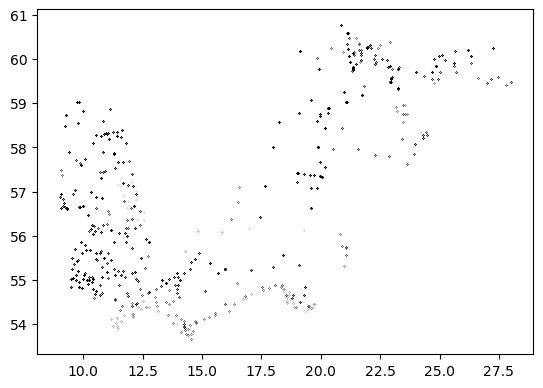

In [14]:
figure("Data")
ax = subplot(1,1,1)
plot(obslon[sel], obslat[sel], "ko", markersize=.1)
aspectratio = 1/cos(mean(latr) * pi/180)
#ax.tick_params("both",labelsize=6)
gca().set_aspect(aspectratio)

#### Set negativ oxygen to 0

In [15]:
if varname == "Oxygen"
    sel = (obsval .< 0.);
    obsval[sel] .= 0.;
end
checkobs((obslon,obslat,obsdepth,obstime),obsval,obsid)    

              minimum and maximum of obs. dimension 1: (9.0, 30.263)
              minimum and maximum of obs. dimension 2: (53.45, 61.016)
              minimum and maximum of obs. dimension 3: 

┌ Info: Checking ranges for dimensions and observations
└ @ DIVAnd C:\Users\a001109\.julia\packages\DIVAnd\Iwjb1\src\obsstat.jl:78


(0.0, 695.5)
              minimum and maximum of obs. dimension 4: (DateTime("1960-01-11T17:00:00"), DateTime("2018-12-21T09:00:00"))
                          minimum and maximum of data: (0.0, 753.43)


#### Plot selected data

## Extract the bathymetry
It is used to delimit the domain where the interpolation is performed.

### Choice of bathymetry
Modify bathname according to the resolution required.

In [16]:
bathname = "./bathymetry/gebco_30sec_8.nc"
bathisglobal = true;
bx,by,b = DIVAnd.extract_bath(bathname,bathisglobal,lonr,latr);
#hx,hy,h = DIVAnd.load_bath(bathname,bathisglobal,lonr,latr);
#mask_h = h .< 0;

## MASK

#### 1) Do a mask

In [17]:
xmask,ymask,mmask = load_mask(bathname,true,lonr,latr,depthr);

#### 2) apply floodfill.
Karin: Varför depthr? borde gå med 0?

It gives you an array which has the same size has the mask, and contains values equal to 0, 1, 2... 
1 corresponds to the largest area, label 2 the 2nd largest and so on... fråga karin

In [18]:
label = DIVAnd.floodfill(mmask);

#### Plot
Maybe it is not so clear, so you can just plot label:

pcolor(xmask, ymask, label[:,:,1]');  # the 1 means the 1st depth level

and you will obtain something like the attached figure. The colored pixels are the "sea" pixels not connected with the main sea area.


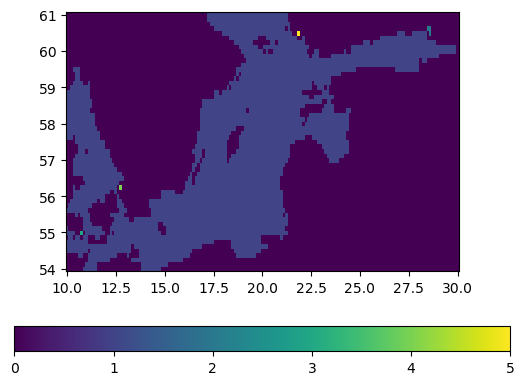

In [19]:
pcolor(xmask, ymask, label[:,:,1]'); 
#pcolor(xmask, ymask, new_mask[:,:,2]'); 
#pcolor(xmask, ymask,(new_mask[:,:,1].*rl)'); 
colorbar(orientation="horizontal")
gca().set_aspect(1/cos(mean([ylim()...]) * pi/180)) # fixes the aspect ratio

#### 3) Create a new mask
new_mask = (label .== 1)

which means it will have the value true only in the main sea area, not on land or in the small isolated pixels.
I also attach a plot with the 2 masks (before and after the floodfill). You can see that your problem with the pixel in the middle of the island has disappeared. Note also that the northwesternmost part of the domain has also been masked, as this area was the 2nd largest sea area.


In [20]:
new_mask = (label .== 1);

## Analysis parameters

## Horizontal correlation length

From https://github.com/gher-uliege/DIVAnd.jl/issues/121 

Here is a piece of code (from Emodnet Chemistry), which could be used to create a correlation length lenfilled decreasing to a fifth of the normal value lenf when approaching a cost.
The distance at which the change happens is defined by slen (here in meters, so metrics pmn are in /m). sz is size(mask)

The mask is 2D.

Ökas slen så minskas avståndet från kusten där len är mindre.

In [21]:
mask,pmn = DIVAnd.domain(bathname,bathisglobal,lonr,latr);

In [22]:
sz_mask = size(mask)
lenf = 50_000.

nearcoast = 1.0 * (1. .- new_mask[:,:,1])
nearcoastf = copy(nearcoast)

slen = (25e3,25e3)
nearcoastf = @time DIVAnd.diffusion(
    trues(sz_mask),pmn,slen,nearcoast;
    boundary_condition! = x -> x[.!new_mask[:,:,1]] .= 1
)


lenf2 = (1 .- nearcoastf) .* lenf + nearcoastf .* lenf/3 #5

#@code_warntype DIVAnd.diffusion(mask,pmn,slen,len)
lenf2[.!new_mask[:,:,1]] .= NaN

lenfilled = DIVAnd.ufill(lenf2,isfinite.(lenf2));

  1.375466 seconds (2.68 M allocations: 149.681 MiB, 99.41% compilation time)


In [23]:
rl = lenfilled ./ lenf;

In [24]:
sz = (length(lonr),length(latr),length(depthr));

#### lx?, ly? rl? sz?

In [25]:
lx = 78_000. #50_000.
ly = 78_000. 
lenx = repeat(rl.*lx,inner=(1,1,sz[3]));
leny = repeat(rl.*ly,inner=(1,1,sz[3]));
#leny = copy(lenx);
#maximum(lenx)

sz = (length(lonr),length(latr),length(depthr));
lx = 80_000. # 80 km
ly = 80_000. # 80 km
lenx = fill(lx,sz)   
leny = fill(ly,sz)  
                       
for k = 1:sz[3]
    for j = 1:sz[2]
        for i = 1:sz[1]
            lenx[i,j,k] = lenx[i,j,k] * RL[i,j]
            leny[i,j,k] = leny[i,j,k] * RL[i,j]
        end
    end
end
#lenx = leny = fill(1,sz);
#lenx=leny=RL3D

## Vertical correlation length

In [26]:
#lenz (twice the resolution)
lenz_ = [50., 10., 10.,10.,10.,10.,
        10.,10.,10.,10.,10.,10.,50.,50.];

#depthr = [50, 55, 60, 65, 70,75, 80, 85, 90, 95, 100, 125, 150];

lenz =  [lenz_[k] for i = 1:sz[1], j = 1:sz[2], k = 1:sz[3]];


#lenz = fill(0,sz);      # scaling factor of one when vertical correlation length is estimated 
#lenz = [10+depthr[k]/15 for i = 1:sz[1], j = 1:sz[2], k = 1:sz[3]]

## Analysis

Remove the result file before running the analysis, otherwise you'll get the message     
```julia
NCDatasets.NetCDFError(13, "Permission denied")
```

### Plotting function
Define a plotting function that will be applied for each time index and depth level.     
All the figures will be saved in a selected directory.

If you do not want to generate plots but print the time index at every time slice
you can use the function `plotres_timeindex`.

In [27]:
#sel = (obsdepth .> 225) .& ((Dates.month.(obstime) .== 12) .| (Dates.month.(obstime) .< 2))

#value = obsval[sel]
#lon = obslon[sel]
#lat = obslat[sel]
#depth = obsdepth[sel]
#time = obstime[sel]
#ids = obsid[sel];
#@show (size(value))
#checkobs((lon,lat,depth,time),value,ids)

## Where to save the result...

In [28]:
# File name based on the variable (but all spaces are replaced by _) _varlenz
outputdir = "./resultat/nc/$(savevar)/" ;
if !isdir(outputdir)
    mkpath(outputdir)
end

figdir = "./resultat/figures/$(savevar)/";
if !isdir(figdir)
    mkpath(figdir)
end

# Run DIVA3d
### Background field is calculated in notebook: 

In [29]:
#filename_background = "Background_file_6y_20230203_$(savevar).nc"

#TS_back = DIVAnd.TimeSelectorYearListMonthList(yearlist_back, monthlist)
#background = DIVAnd.backgroundfile(filename_background,varname,TS_back)

In [30]:
# To include December from previous year in the analyse
obstime_shifted = copy(obstime)
obstime_shifted[Dates.month.(obstime) .== 12] .+= Dates.Year(1)

# When cutting
#polygon_lon = [9.4, 11., 31., 31., 14., 14., 9.4]
#polygon_lat = [54., 53., 53., 66., 66., 55.5, 55.5]

# Settings for DIVAnd
epsilon=0.001
error_thresholds = [("L1", 0.3), ("L2", 0.5)];
solver = :direct
epsilon2 = 1.;

#### Loop each season

In [31]:
epsilon2

1.0

In [32]:
for i in 1:length(monthlist)
    
    @info("starting DIVAnd computations for $(seasons[i])")
    @info(Dates.now())
    
    function plotres(timeindex,sel,fit,erri)
        @show timeindex
        tmp = copy(fit)
        tmp[erri .> .5] .= NaN;
        figure(figsize = (10,8))
        subplot(2,1,1)
        title("$(yearlist[timeindex]),$(seasons[i]) - surface")

        # select the data near the surface
        sel_halo = sel .& (obsdepth .> 125.)
        #vmin = vmin_ #minimum(obsval[selsurface])
        #vmax = vmax #maximum(obsval[selsurface])

        # plot the data
        
        xlim(minimum(lonr),maximum(lonr))
        ylim(minimum(latr),maximum(latr))
        contourf(bx,by,permutedims(b,[2,1]), levels = [-1e5,0],colors = [[.5,.5,.5]])
        gca().set_aspect(aspect_ratio)
        scatter(obslon[sel_halo],obslat[sel_halo],10,obsval[sel_halo];
                vmin = vmin_, vmax = vmax_, cmap="jet")  #"PuBuGn","viridis"
        colorbar(extend="max")

        # plot the analysis
        subplot(2,1,2)
        #title("L=$(L)[m], lenx=$(lx)[m], leny=$(ly)[m]")
        pcolor(lonr,latr,permutedims(tmp[:,:,14],[2,1]);
               vmin = vmin_, vmax = vmax_, cmap="jet")
        colorbar(extend="max")
        contourf(bx,by,permutedims(b,[2,1]), levels = [-1e5,0],colors = [[.5,.5,.5]])
        gca().set_aspect(aspect_ratio)

        # save the figure
        figname = savevar * @sprintf("_halo_") *  seasons[i] * @sprintf("_%03d.png",timeindex)
        PyPlot.savefig(joinpath(figdir, figname), dpi=300, bbox_inches="tight");
        PyPlot.close_figs()    
    end
    
    
    # Time selection for the analyse
    TS = DIVAnd.TimeSelectorYearListMonthList(yearlist,monthlist[i:i])
    
    # File name based on the variable (but all spaces are replaced by _)  
    filename = joinpath(outputdir, "$(replace(varname,' '=>'_'))_$(seasons[i])_$(yearlist[i])_0.4Danl.nc")
                
    if isfile(filename)
       rm(filename) # delete the previous analysis
    end
    
    @info("Will write results in $filename")
    
    # create attributes for the netcdf file (need an internet connexion)
    ncglobalattrib,ncvarattrib = SDNMetadata(metadata[i],filename,varname,lonr,latr)
        
    
    @time dbinfo = diva3d((lonr,latr,depthr,TS),
              (obslon,obslat,obsdepth,obstime_shifted),
              obsval,
              (lenx,leny,lenz),
              epsilon2,
              filename,varname,
              bathname = bathname,
              bathisglobal = bathisglobal,
              plotres = plotres,
              ncvarattrib = ncvarattrib,
              ncglobalattrib = ncglobalattrib,
              timeorigin = timeorigin,
              transform = Anam.loglin(epsilon),   
              mask = new_mask,
              solver = solver,
              niter_e = 1,
              error_thresholds = error_thresholds,
              surfextend = true,
              alphabc = 0,
              MEMTOFIT = 120
       );
    
    # Save the observation metadata in the NetCDF file
    DIVAnd.saveobs(filename,(obslon,obslat,obsdepth,obstime),obsid,used = dbinfo[:used])
    
    ## Deepest value
    deep_filename = joinpath(outputdir, "$(replace(varname,' '=>'_'))_$(seasons[i])_deep.4Danl.nc")
    DIVAnd.derived(filename,varname,deep_filename,error_thresholds = error_thresholds)
     
    ## cut net cdf
    #cut_filename = joinpath(outputdir, "$(replace(varname,' '=>'_'))_$(seasons[i]).4Danl.nc")
    #DIVAnd.cut(deep_filename,varname,cut_filename,polygon_lon,polygon_lat)
       
    #residual = dbinfo[:residuals]
    #res = get(dbinfo, :residuals, 0)
    #@show extrema(res);
    #dataresiduals=divand_residualobs(s,fi)
        
end


┌ Info: starting DIVAnd computations for Winter
└ @ Main In[32]:3
┌ Info: 2023-04-17T10:02:31.840
└ @ Main In[32]:4
┌ Info: Will write results in ./resultat/nc/O2/Oxygen_Winter_2010_0.4Danl.nc
└ @ Main In[32]:55
┌ Info: Creating netCDF file ./resultat/nc/O2/Oxygen_Winter_2010_0.4Danl.nc
└ @ DIVAnd C:\Users\a001109\.julia\packages\DIVAnd\Iwjb1\src\diva.jl:374
┌ Info: Time step 1 / 8
└ @ DIVAnd C:\Users\a001109\.julia\packages\DIVAnd\Iwjb1\src\diva.jl:427
┌ Warning: Observations equal to NaN: 121
└ @ DIVAnd C:\Users\a001109\.julia\packages\DIVAnd\Iwjb1\src\DIVAnd_obs.jl:45
┌ Info: scaled correlation length (min,max) in dimension 1: (26007.848779537788, 77999.9918075985)
└ @ DIVAnd C:\Users\a001109\.julia\packages\DIVAnd\Iwjb1\src\diva.jl:612
┌ Info: scaled correlation length (min,max) in dimension 2: (26007.848779537788, 77999.9918075985)
└ @ DIVAnd C:\Users\a001109\.julia\packages\DIVAnd\Iwjb1\src\diva.jl:612
┌ Info: scaled correlation length (min,max) in dimension 3: (10.0, 50.0)
└ @ D

timeindex = 1


┌ Info: Time step 2 / 8
└ @ DIVAnd C:\Users\a001109\.julia\packages\DIVAnd\Iwjb1\src\diva.jl:427
┌ Warning: Observations equal to NaN: 61
└ @ DIVAnd C:\Users\a001109\.julia\packages\DIVAnd\Iwjb1\src\DIVAnd_obs.jl:45
┌ Info: scaled correlation length (min,max) in dimension 1: (26007.848779537788, 77999.9918075985)
└ @ DIVAnd C:\Users\a001109\.julia\packages\DIVAnd\Iwjb1\src\diva.jl:612
┌ Info: scaled correlation length (min,max) in dimension 2: (26007.848779537788, 77999.9918075985)
└ @ DIVAnd C:\Users\a001109\.julia\packages\DIVAnd\Iwjb1\src\diva.jl:612
┌ Info: scaled correlation length (min,max) in dimension 3: (10.0, 50.0)
└ @ DIVAnd C:\Users\a001109\.julia\packages\DIVAnd\Iwjb1\src\diva.jl:612
┌ Warning: resolution (13899.385465521233) is too coarse for correlation length 27344.109094788164 in dimension 2 at indices CartesianIndex(28, 3, 1) (skipping further tests). It is recommended that the resolution is at least 2 times finer than the correlation length.
└ @ DIVAnd C:\Users\a0011

timeindex = 2


┌ Info: Time step 3 / 8
└ @ DIVAnd C:\Users\a001109\.julia\packages\DIVAnd\Iwjb1\src\diva.jl:427
┌ Warning: Observations equal to NaN: 50
└ @ DIVAnd C:\Users\a001109\.julia\packages\DIVAnd\Iwjb1\src\DIVAnd_obs.jl:45
┌ Info: scaled correlation length (min,max) in dimension 1: (26007.848779537788, 77999.9918075985)
└ @ DIVAnd C:\Users\a001109\.julia\packages\DIVAnd\Iwjb1\src\diva.jl:612
┌ Info: scaled correlation length (min,max) in dimension 2: (26007.848779537788, 77999.9918075985)
└ @ DIVAnd C:\Users\a001109\.julia\packages\DIVAnd\Iwjb1\src\diva.jl:612
┌ Info: scaled correlation length (min,max) in dimension 3: (10.0, 50.0)
└ @ DIVAnd C:\Users\a001109\.julia\packages\DIVAnd\Iwjb1\src\diva.jl:612
┌ Warning: resolution (13899.385465521233) is too coarse for correlation length 27344.109094788164 in dimension 2 at indices CartesianIndex(28, 3, 1) (skipping further tests). It is recommended that the resolution is at least 2 times finer than the correlation length.
└ @ DIVAnd C:\Users\a0011

timeindex = 3


┌ Info: Time step 4 / 8
└ @ DIVAnd C:\Users\a001109\.julia\packages\DIVAnd\Iwjb1\src\diva.jl:427
┌ Warning: Observations equal to NaN: 111
└ @ DIVAnd C:\Users\a001109\.julia\packages\DIVAnd\Iwjb1\src\DIVAnd_obs.jl:45
┌ Info: scaled correlation length (min,max) in dimension 1: (26007.848779537788, 77999.9918075985)
└ @ DIVAnd C:\Users\a001109\.julia\packages\DIVAnd\Iwjb1\src\diva.jl:612
┌ Info: scaled correlation length (min,max) in dimension 2: (26007.848779537788, 77999.9918075985)
└ @ DIVAnd C:\Users\a001109\.julia\packages\DIVAnd\Iwjb1\src\diva.jl:612
┌ Info: scaled correlation length (min,max) in dimension 3: (10.0, 50.0)
└ @ DIVAnd C:\Users\a001109\.julia\packages\DIVAnd\Iwjb1\src\diva.jl:612
┌ Warning: resolution (13899.385465521233) is too coarse for correlation length 27344.109094788164 in dimension 2 at indices CartesianIndex(28, 3, 1) (skipping further tests). It is recommended that the resolution is at least 2 times finer than the correlation length.
└ @ DIVAnd C:\Users\a001

timeindex = 4


┌ Info: Time step 5 / 8
└ @ DIVAnd C:\Users\a001109\.julia\packages\DIVAnd\Iwjb1\src\diva.jl:427
┌ Warning: Observations equal to NaN: 30
└ @ DIVAnd C:\Users\a001109\.julia\packages\DIVAnd\Iwjb1\src\DIVAnd_obs.jl:45
┌ Info: scaled correlation length (min,max) in dimension 1: (26007.848779537788, 77999.9918075985)
└ @ DIVAnd C:\Users\a001109\.julia\packages\DIVAnd\Iwjb1\src\diva.jl:612
┌ Info: scaled correlation length (min,max) in dimension 2: (26007.848779537788, 77999.9918075985)
└ @ DIVAnd C:\Users\a001109\.julia\packages\DIVAnd\Iwjb1\src\diva.jl:612
┌ Info: scaled correlation length (min,max) in dimension 3: (10.0, 50.0)
└ @ DIVAnd C:\Users\a001109\.julia\packages\DIVAnd\Iwjb1\src\diva.jl:612
┌ Warning: resolution (13899.385465521233) is too coarse for correlation length 27344.109094788164 in dimension 2 at indices CartesianIndex(28, 3, 1) (skipping further tests). It is recommended that the resolution is at least 2 times finer than the correlation length.
└ @ DIVAnd C:\Users\a0011

timeindex = 5


┌ Info: Time step 6 / 8
└ @ DIVAnd C:\Users\a001109\.julia\packages\DIVAnd\Iwjb1\src\diva.jl:427
┌ Warning: Observations equal to NaN: 41
└ @ DIVAnd C:\Users\a001109\.julia\packages\DIVAnd\Iwjb1\src\DIVAnd_obs.jl:45
┌ Info: scaled correlation length (min,max) in dimension 1: (26007.848779537788, 77999.9918075985)
└ @ DIVAnd C:\Users\a001109\.julia\packages\DIVAnd\Iwjb1\src\diva.jl:612
┌ Info: scaled correlation length (min,max) in dimension 2: (26007.848779537788, 77999.9918075985)
└ @ DIVAnd C:\Users\a001109\.julia\packages\DIVAnd\Iwjb1\src\diva.jl:612
┌ Info: scaled correlation length (min,max) in dimension 3: (10.0, 50.0)
└ @ DIVAnd C:\Users\a001109\.julia\packages\DIVAnd\Iwjb1\src\diva.jl:612
┌ Warning: resolution (13899.385465521233) is too coarse for correlation length 27344.109094788164 in dimension 2 at indices CartesianIndex(28, 3, 1) (skipping further tests). It is recommended that the resolution is at least 2 times finer than the correlation length.
└ @ DIVAnd C:\Users\a0011

timeindex = 6


┌ Info: number of windows: 1
└ @ DIVAnd C:\Users\a001109\.julia\packages\DIVAnd\Iwjb1\src\DIVAndgo.jl:110
┌ Info: Time step 7 / 8
└ @ DIVAnd C:\Users\a001109\.julia\packages\DIVAnd\Iwjb1\src\diva.jl:427
┌ Warning: Observations equal to NaN: 17
└ @ DIVAnd C:\Users\a001109\.julia\packages\DIVAnd\Iwjb1\src\DIVAnd_obs.jl:45
┌ Info: scaled correlation length (min,max) in dimension 1: (26007.848779537788, 77999.9918075985)
└ @ DIVAnd C:\Users\a001109\.julia\packages\DIVAnd\Iwjb1\src\diva.jl:612
┌ Info: scaled correlation length (min,max) in dimension 2: (26007.848779537788, 77999.9918075985)
└ @ DIVAnd C:\Users\a001109\.julia\packages\DIVAnd\Iwjb1\src\diva.jl:612
┌ Info: scaled correlation length (min,max) in dimension 3: (10.0, 50.0)
└ @ DIVAnd C:\Users\a001109\.julia\packages\DIVAnd\Iwjb1\src\diva.jl:612
┌ Warning: resolution (13899.385465521233) is too coarse for correlation length 27344.109094788164 in dimension 2 at indices CartesianIndex(28, 3, 1) (skipping further tests). It is recomm

timeindex = 7


┌ Info: Time step 8 / 8
└ @ DIVAnd C:\Users\a001109\.julia\packages\DIVAnd\Iwjb1\src\diva.jl:427
┌ Warning: Observations equal to NaN: 28
└ @ DIVAnd C:\Users\a001109\.julia\packages\DIVAnd\Iwjb1\src\DIVAnd_obs.jl:45
┌ Info: scaled correlation length (min,max) in dimension 1: (26007.848779537788, 77999.9918075985)
└ @ DIVAnd C:\Users\a001109\.julia\packages\DIVAnd\Iwjb1\src\diva.jl:612
┌ Info: scaled correlation length (min,max) in dimension 2: (26007.848779537788, 77999.9918075985)
└ @ DIVAnd C:\Users\a001109\.julia\packages\DIVAnd\Iwjb1\src\diva.jl:612
┌ Info: scaled correlation length (min,max) in dimension 3: (10.0, 50.0)
└ @ DIVAnd C:\Users\a001109\.julia\packages\DIVAnd\Iwjb1\src\diva.jl:612
┌ Warning: resolution (13899.385465521233) is too coarse for correlation length 27344.109094788164 in dimension 2 at indices CartesianIndex(28, 3, 1) (skipping further tests). It is recommended that the resolution is at least 2 times finer than the correlation length.
└ @ DIVAnd C:\Users\a0011

timeindex = 8
108.625058 seconds (159.59 M allocations: 28.011 GiB, 7.02% gc time, 0.01% compilation time)


┌ Info: Creating new variable Oxygen_deepest
└ @ DIVAnd C:\Users\a001109\.julia\packages\DIVAnd\Iwjb1\src\derived.jl:40
┌ Info: Working on 14 depth layers
└ @ DIVAnd C:\Users\a001109\.julia\packages\DIVAnd\Iwjb1\src\derived.jl:120
┌ Info: size = (161, 57, 14)
└ @ DIVAnd C:\Users\a001109\.julia\packages\DIVAnd\Iwjb1\src\derived.jl:125
┌ Info: Creating new variable Oxygen_deepest_depth
└ @ DIVAnd C:\Users\a001109\.julia\packages\DIVAnd\Iwjb1\src\derived.jl:131
┌ Info: Depth index: 1
└ @ DIVAnd C:\Users\a001109\.julia\packages\DIVAnd\Iwjb1\src\derived.jl:143
┌ Info: Found 3248 non missing values for depth 0.0
└ @ DIVAnd C:\Users\a001109\.julia\packages\DIVAnd\Iwjb1\src\derived.jl:146
┌ Info: Depth index: 2
└ @ DIVAnd C:\Users\a001109\.julia\packages\DIVAnd\Iwjb1\src\derived.jl:143
┌ Info: Found 1281 non missing values for depth 50.0
└ @ DIVAnd C:\Users\a001109\.julia\packages\DIVAnd\Iwjb1\src\derived.jl:146
┌ Info: Depth index: 3
└ @ DIVAnd C:\Users\a001109\.julia\packages\DIVAnd\Iwjb1\sr

timeindex = 1


┌ Info: number of windows: 1
└ @ DIVAnd C:\Users\a001109\.julia\packages\DIVAnd\Iwjb1\src\DIVAndgo.jl:110
┌ Info: Time step 2 / 8
└ @ DIVAnd C:\Users\a001109\.julia\packages\DIVAnd\Iwjb1\src\diva.jl:427
┌ Warning: Observations equal to NaN: 153
└ @ DIVAnd C:\Users\a001109\.julia\packages\DIVAnd\Iwjb1\src\DIVAnd_obs.jl:45
┌ Info: scaled correlation length (min,max) in dimension 1: (26007.848779537788, 77999.9918075985)
└ @ DIVAnd C:\Users\a001109\.julia\packages\DIVAnd\Iwjb1\src\diva.jl:612
┌ Info: scaled correlation length (min,max) in dimension 2: (26007.848779537788, 77999.9918075985)
└ @ DIVAnd C:\Users\a001109\.julia\packages\DIVAnd\Iwjb1\src\diva.jl:612
┌ Info: scaled correlation length (min,max) in dimension 3: (10.0, 50.0)
└ @ DIVAnd C:\Users\a001109\.julia\packages\DIVAnd\Iwjb1\src\diva.jl:612
┌ Warning: resolution (13899.385465521233) is too coarse for correlation length 27344.109094788164 in dimension 2 at indices CartesianIndex(28, 3, 1) (skipping further tests). It is recom

timeindex = 2


┌ Info: Time step 3 / 8
└ @ DIVAnd C:\Users\a001109\.julia\packages\DIVAnd\Iwjb1\src\diva.jl:427
┌ Warning: Observations equal to NaN: 149
└ @ DIVAnd C:\Users\a001109\.julia\packages\DIVAnd\Iwjb1\src\DIVAnd_obs.jl:45
┌ Info: scaled correlation length (min,max) in dimension 1: (26007.848779537788, 77999.9918075985)
└ @ DIVAnd C:\Users\a001109\.julia\packages\DIVAnd\Iwjb1\src\diva.jl:612
┌ Info: scaled correlation length (min,max) in dimension 2: (26007.848779537788, 77999.9918075985)
└ @ DIVAnd C:\Users\a001109\.julia\packages\DIVAnd\Iwjb1\src\diva.jl:612
┌ Info: scaled correlation length (min,max) in dimension 3: (10.0, 50.0)
└ @ DIVAnd C:\Users\a001109\.julia\packages\DIVAnd\Iwjb1\src\diva.jl:612
┌ Warning: resolution (13899.385465521233) is too coarse for correlation length 27344.109094788164 in dimension 2 at indices CartesianIndex(28, 3, 1) (skipping further tests). It is recommended that the resolution is at least 2 times finer than the correlation length.
└ @ DIVAnd C:\Users\a001

timeindex = 3


┌ Info: number of windows: 1
└ @ DIVAnd C:\Users\a001109\.julia\packages\DIVAnd\Iwjb1\src\DIVAndgo.jl:110
┌ Info: Time step 4 / 8
└ @ DIVAnd C:\Users\a001109\.julia\packages\DIVAnd\Iwjb1\src\diva.jl:427
┌ Warning: Observations equal to NaN: 156
└ @ DIVAnd C:\Users\a001109\.julia\packages\DIVAnd\Iwjb1\src\DIVAnd_obs.jl:45
┌ Info: scaled correlation length (min,max) in dimension 1: (26007.848779537788, 77999.9918075985)
└ @ DIVAnd C:\Users\a001109\.julia\packages\DIVAnd\Iwjb1\src\diva.jl:612
┌ Info: scaled correlation length (min,max) in dimension 2: (26007.848779537788, 77999.9918075985)
└ @ DIVAnd C:\Users\a001109\.julia\packages\DIVAnd\Iwjb1\src\diva.jl:612
┌ Info: scaled correlation length (min,max) in dimension 3: (10.0, 50.0)
└ @ DIVAnd C:\Users\a001109\.julia\packages\DIVAnd\Iwjb1\src\diva.jl:612
┌ Warning: resolution (13899.385465521233) is too coarse for correlation length 27344.109094788164 in dimension 2 at indices CartesianIndex(28, 3, 1) (skipping further tests). It is recom

timeindex = 4


┌ Info: number of windows: 1
└ @ DIVAnd C:\Users\a001109\.julia\packages\DIVAnd\Iwjb1\src\DIVAndgo.jl:110
┌ Info: Time step 5 / 8
└ @ DIVAnd C:\Users\a001109\.julia\packages\DIVAnd\Iwjb1\src\diva.jl:427
┌ Warning: Observations equal to NaN: 20
└ @ DIVAnd C:\Users\a001109\.julia\packages\DIVAnd\Iwjb1\src\DIVAnd_obs.jl:45
┌ Info: scaled correlation length (min,max) in dimension 1: (26007.848779537788, 77999.9918075985)
└ @ DIVAnd C:\Users\a001109\.julia\packages\DIVAnd\Iwjb1\src\diva.jl:612
┌ Info: scaled correlation length (min,max) in dimension 2: (26007.848779537788, 77999.9918075985)
└ @ DIVAnd C:\Users\a001109\.julia\packages\DIVAnd\Iwjb1\src\diva.jl:612
┌ Info: scaled correlation length (min,max) in dimension 3: (10.0, 50.0)
└ @ DIVAnd C:\Users\a001109\.julia\packages\DIVAnd\Iwjb1\src\diva.jl:612
┌ Warning: resolution (13899.385465521233) is too coarse for correlation length 27344.109094788164 in dimension 2 at indices CartesianIndex(28, 3, 1) (skipping further tests). It is recomm

timeindex = 5


┌ Info: Time step 6 / 8
└ @ DIVAnd C:\Users\a001109\.julia\packages\DIVAnd\Iwjb1\src\diva.jl:427
┌ Warning: Observations equal to NaN: 24
└ @ DIVAnd C:\Users\a001109\.julia\packages\DIVAnd\Iwjb1\src\DIVAnd_obs.jl:45
┌ Info: scaled correlation length (min,max) in dimension 1: (26007.848779537788, 77999.9918075985)
└ @ DIVAnd C:\Users\a001109\.julia\packages\DIVAnd\Iwjb1\src\diva.jl:612
┌ Info: scaled correlation length (min,max) in dimension 2: (26007.848779537788, 77999.9918075985)
└ @ DIVAnd C:\Users\a001109\.julia\packages\DIVAnd\Iwjb1\src\diva.jl:612
┌ Info: scaled correlation length (min,max) in dimension 3: (10.0, 50.0)
└ @ DIVAnd C:\Users\a001109\.julia\packages\DIVAnd\Iwjb1\src\diva.jl:612
┌ Warning: resolution (13899.385465521233) is too coarse for correlation length 27344.109094788164 in dimension 2 at indices CartesianIndex(28, 3, 1) (skipping further tests). It is recommended that the resolution is at least 2 times finer than the correlation length.
└ @ DIVAnd C:\Users\a0011

timeindex = 6


┌ Info: Time step 7 / 8
└ @ DIVAnd C:\Users\a001109\.julia\packages\DIVAnd\Iwjb1\src\diva.jl:427
┌ Warning: Observations equal to NaN: 15
└ @ DIVAnd C:\Users\a001109\.julia\packages\DIVAnd\Iwjb1\src\DIVAnd_obs.jl:45
┌ Info: scaled correlation length (min,max) in dimension 1: (26007.848779537788, 77999.9918075985)
└ @ DIVAnd C:\Users\a001109\.julia\packages\DIVAnd\Iwjb1\src\diva.jl:612
┌ Info: scaled correlation length (min,max) in dimension 2: (26007.848779537788, 77999.9918075985)
└ @ DIVAnd C:\Users\a001109\.julia\packages\DIVAnd\Iwjb1\src\diva.jl:612
┌ Info: scaled correlation length (min,max) in dimension 3: (10.0, 50.0)
└ @ DIVAnd C:\Users\a001109\.julia\packages\DIVAnd\Iwjb1\src\diva.jl:612
┌ Warning: resolution (13899.385465521233) is too coarse for correlation length 27344.109094788164 in dimension 2 at indices CartesianIndex(28, 3, 1) (skipping further tests). It is recommended that the resolution is at least 2 times finer than the correlation length.
└ @ DIVAnd C:\Users\a0011

timeindex = 7


┌ Info: Time step 8 / 8
└ @ DIVAnd C:\Users\a001109\.julia\packages\DIVAnd\Iwjb1\src\diva.jl:427
┌ Warning: Observations equal to NaN: 2
└ @ DIVAnd C:\Users\a001109\.julia\packages\DIVAnd\Iwjb1\src\DIVAnd_obs.jl:45
┌ Info: scaled correlation length (min,max) in dimension 1: (26007.848779537788, 77999.9918075985)
└ @ DIVAnd C:\Users\a001109\.julia\packages\DIVAnd\Iwjb1\src\diva.jl:612
┌ Info: scaled correlation length (min,max) in dimension 2: (26007.848779537788, 77999.9918075985)
└ @ DIVAnd C:\Users\a001109\.julia\packages\DIVAnd\Iwjb1\src\diva.jl:612
┌ Info: scaled correlation length (min,max) in dimension 3: (10.0, 50.0)
└ @ DIVAnd C:\Users\a001109\.julia\packages\DIVAnd\Iwjb1\src\diva.jl:612
┌ Warning: resolution (13899.385465521233) is too coarse for correlation length 27344.109094788164 in dimension 2 at indices CartesianIndex(28, 3, 1) (skipping further tests). It is recommended that the resolution is at least 2 times finer than the correlation length.
└ @ DIVAnd C:\Users\a00110

timeindex = 8
 24.810760 seconds (132.49 k allocations: 19.028 GiB, 15.08% gc time, 0.09% compilation time)


┌ Info: Creating new variable Oxygen_deepest
└ @ DIVAnd C:\Users\a001109\.julia\packages\DIVAnd\Iwjb1\src\derived.jl:40
┌ Info: Working on 14 depth layers
└ @ DIVAnd C:\Users\a001109\.julia\packages\DIVAnd\Iwjb1\src\derived.jl:120
┌ Info: size = (161, 57, 14)
└ @ DIVAnd C:\Users\a001109\.julia\packages\DIVAnd\Iwjb1\src\derived.jl:125
┌ Info: Creating new variable Oxygen_deepest_depth
└ @ DIVAnd C:\Users\a001109\.julia\packages\DIVAnd\Iwjb1\src\derived.jl:131
┌ Info: Depth index: 1
└ @ DIVAnd C:\Users\a001109\.julia\packages\DIVAnd\Iwjb1\src\derived.jl:143
┌ Info: Found 3248 non missing values for depth 0.0
└ @ DIVAnd C:\Users\a001109\.julia\packages\DIVAnd\Iwjb1\src\derived.jl:146
┌ Info: Depth index: 2
└ @ DIVAnd C:\Users\a001109\.julia\packages\DIVAnd\Iwjb1\src\derived.jl:143
┌ Info: Found 1281 non missing values for depth 50.0
└ @ DIVAnd C:\Users\a001109\.julia\packages\DIVAnd\Iwjb1\src\derived.jl:146
┌ Info: Depth index: 3
└ @ DIVAnd C:\Users\a001109\.julia\packages\DIVAnd\Iwjb1\sr

timeindex = 1


┌ Info: number of windows: 1
└ @ DIVAnd C:\Users\a001109\.julia\packages\DIVAnd\Iwjb1\src\DIVAndgo.jl:110
┌ Info: Time step 2 / 8
└ @ DIVAnd C:\Users\a001109\.julia\packages\DIVAnd\Iwjb1\src\diva.jl:427
┌ Warning: Observations equal to NaN: 185
└ @ DIVAnd C:\Users\a001109\.julia\packages\DIVAnd\Iwjb1\src\DIVAnd_obs.jl:45
┌ Info: scaled correlation length (min,max) in dimension 1: (26007.848779537788, 77999.9918075985)
└ @ DIVAnd C:\Users\a001109\.julia\packages\DIVAnd\Iwjb1\src\diva.jl:612
┌ Info: scaled correlation length (min,max) in dimension 2: (26007.848779537788, 77999.9918075985)
└ @ DIVAnd C:\Users\a001109\.julia\packages\DIVAnd\Iwjb1\src\diva.jl:612
┌ Info: scaled correlation length (min,max) in dimension 3: (10.0, 50.0)
└ @ DIVAnd C:\Users\a001109\.julia\packages\DIVAnd\Iwjb1\src\diva.jl:612
┌ Warning: resolution (13899.385465521233) is too coarse for correlation length 27344.109094788164 in dimension 2 at indices CartesianIndex(28, 3, 1) (skipping further tests). It is recom

timeindex = 2


┌ Info: Time step 3 / 8
└ @ DIVAnd C:\Users\a001109\.julia\packages\DIVAnd\Iwjb1\src\diva.jl:427
┌ Warning: Observations equal to NaN: 175
└ @ DIVAnd C:\Users\a001109\.julia\packages\DIVAnd\Iwjb1\src\DIVAnd_obs.jl:45
┌ Info: scaled correlation length (min,max) in dimension 1: (26007.848779537788, 77999.9918075985)
└ @ DIVAnd C:\Users\a001109\.julia\packages\DIVAnd\Iwjb1\src\diva.jl:612
┌ Info: scaled correlation length (min,max) in dimension 2: (26007.848779537788, 77999.9918075985)
└ @ DIVAnd C:\Users\a001109\.julia\packages\DIVAnd\Iwjb1\src\diva.jl:612
┌ Info: scaled correlation length (min,max) in dimension 3: (10.0, 50.0)
└ @ DIVAnd C:\Users\a001109\.julia\packages\DIVAnd\Iwjb1\src\diva.jl:612
┌ Warning: resolution (13899.385465521233) is too coarse for correlation length 27344.109094788164 in dimension 2 at indices CartesianIndex(28, 3, 1) (skipping further tests). It is recommended that the resolution is at least 2 times finer than the correlation length.
└ @ DIVAnd C:\Users\a001

timeindex = 3


┌ Info: number of windows: 1
└ @ DIVAnd C:\Users\a001109\.julia\packages\DIVAnd\Iwjb1\src\DIVAndgo.jl:110
┌ Info: Time step 4 / 8
└ @ DIVAnd C:\Users\a001109\.julia\packages\DIVAnd\Iwjb1\src\diva.jl:427
┌ Warning: Observations equal to NaN: 208
└ @ DIVAnd C:\Users\a001109\.julia\packages\DIVAnd\Iwjb1\src\DIVAnd_obs.jl:45
┌ Info: scaled correlation length (min,max) in dimension 1: (26007.848779537788, 77999.9918075985)
└ @ DIVAnd C:\Users\a001109\.julia\packages\DIVAnd\Iwjb1\src\diva.jl:612
┌ Info: scaled correlation length (min,max) in dimension 2: (26007.848779537788, 77999.9918075985)
└ @ DIVAnd C:\Users\a001109\.julia\packages\DIVAnd\Iwjb1\src\diva.jl:612
┌ Info: scaled correlation length (min,max) in dimension 3: (10.0, 50.0)
└ @ DIVAnd C:\Users\a001109\.julia\packages\DIVAnd\Iwjb1\src\diva.jl:612
┌ Warning: resolution (13899.385465521233) is too coarse for correlation length 27344.109094788164 in dimension 2 at indices CartesianIndex(28, 3, 1) (skipping further tests). It is recom

timeindex = 4

┌ Info: number of windows: 1
└ @ DIVAnd C:\Users\a001109\.julia\packages\DIVAnd\Iwjb1\src\DIVAndgo.jl:110


┌ Info: Time step 5 / 8
└ @ DIVAnd C:\Users\a001109\.julia\packages\DIVAnd\Iwjb1\src\diva.jl:427
┌ Warning: Observations equal to NaN: 115
└ @ DIVAnd C:\Users\a001109\.julia\packages\DIVAnd\Iwjb1\src\DIVAnd_obs.jl:45
┌ Info: scaled correlation length (min,max) in dimension 1: (26007.848779537788, 77999.9918075985)
└ @ DIVAnd C:\Users\a001109\.julia\packages\DIVAnd\Iwjb1\src\diva.jl:612
┌ Info: scaled correlation length (min,max) in dimension 2: (26007.848779537788, 77999.9918075985)
└ @ DIVAnd C:\Users\a001109\.julia\packages\DIVAnd\Iwjb1\src\diva.jl:612
┌ Info: scaled correlation length (min,max) in dimension 3: (10.0, 50.0)
└ @ DIVAnd C:\Users\a001109\.julia\packages\DIVAnd\Iwjb1\src\diva.jl:612
┌ Warning: resolution (13899.385465521233) is too coarse for correlation length 27344.109094788164 in dimension 2 at indices CartesianIndex(28, 3, 1) (skipping further tests). It is recommended that the resolution is at least 2 times finer than the correlation length.
└ @ DIVAnd C:\Users\a001

timeindex = 5


┌ Info: Time step 6 / 8
└ @ DIVAnd C:\Users\a001109\.julia\packages\DIVAnd\Iwjb1\src\diva.jl:427
┌ Warning: Observations equal to NaN: 137
└ @ DIVAnd C:\Users\a001109\.julia\packages\DIVAnd\Iwjb1\src\DIVAnd_obs.jl:45
┌ Info: scaled correlation length (min,max) in dimension 1: (26007.848779537788, 77999.9918075985)
└ @ DIVAnd C:\Users\a001109\.julia\packages\DIVAnd\Iwjb1\src\diva.jl:612
┌ Info: scaled correlation length (min,max) in dimension 2: (26007.848779537788, 77999.9918075985)
└ @ DIVAnd C:\Users\a001109\.julia\packages\DIVAnd\Iwjb1\src\diva.jl:612
┌ Info: scaled correlation length (min,max) in dimension 3: (10.0, 50.0)
└ @ DIVAnd C:\Users\a001109\.julia\packages\DIVAnd\Iwjb1\src\diva.jl:612
┌ Warning: resolution (13899.385465521233) is too coarse for correlation length 27344.109094788164 in dimension 2 at indices CartesianIndex(28, 3, 1) (skipping further tests). It is recommended that the resolution is at least 2 times finer than the correlation length.
└ @ DIVAnd C:\Users\a001

timeindex = 6


┌ Info: Time step 7 / 8
└ @ DIVAnd C:\Users\a001109\.julia\packages\DIVAnd\Iwjb1\src\diva.jl:427
┌ Warning: Observations equal to NaN: 47
└ @ DIVAnd C:\Users\a001109\.julia\packages\DIVAnd\Iwjb1\src\DIVAnd_obs.jl:45
┌ Info: scaled correlation length (min,max) in dimension 1: (26007.848779537788, 77999.9918075985)
└ @ DIVAnd C:\Users\a001109\.julia\packages\DIVAnd\Iwjb1\src\diva.jl:612
┌ Info: scaled correlation length (min,max) in dimension 2: (26007.848779537788, 77999.9918075985)
└ @ DIVAnd C:\Users\a001109\.julia\packages\DIVAnd\Iwjb1\src\diva.jl:612
┌ Info: scaled correlation length (min,max) in dimension 3: (10.0, 50.0)
└ @ DIVAnd C:\Users\a001109\.julia\packages\DIVAnd\Iwjb1\src\diva.jl:612
┌ Warning: resolution (13899.385465521233) is too coarse for correlation length 27344.109094788164 in dimension 2 at indices CartesianIndex(28, 3, 1) (skipping further tests). It is recommended that the resolution is at least 2 times finer than the correlation length.
└ @ DIVAnd C:\Users\a0011

timeindex = 7


┌ Info: Time step 8 / 8
└ @ DIVAnd C:\Users\a001109\.julia\packages\DIVAnd\Iwjb1\src\diva.jl:427
┌ Warning: Observations equal to NaN: 110
└ @ DIVAnd C:\Users\a001109\.julia\packages\DIVAnd\Iwjb1\src\DIVAnd_obs.jl:45
┌ Info: scaled correlation length (min,max) in dimension 1: (26007.848779537788, 77999.9918075985)
└ @ DIVAnd C:\Users\a001109\.julia\packages\DIVAnd\Iwjb1\src\diva.jl:612
┌ Info: scaled correlation length (min,max) in dimension 2: (26007.848779537788, 77999.9918075985)
└ @ DIVAnd C:\Users\a001109\.julia\packages\DIVAnd\Iwjb1\src\diva.jl:612
┌ Info: scaled correlation length (min,max) in dimension 3: (10.0, 50.0)
└ @ DIVAnd C:\Users\a001109\.julia\packages\DIVAnd\Iwjb1\src\diva.jl:612
┌ Warning: resolution (13899.385465521233) is too coarse for correlation length 27344.109094788164 in dimension 2 at indices CartesianIndex(28, 3, 1) (skipping further tests). It is recommended that the resolution is at least 2 times finer than the correlation length.
└ @ DIVAnd C:\Users\a001

timeindex = 8
 23.855325 seconds (112.14 k allocations: 18.979 GiB, 14.68% gc time)


┌ Info: Creating new variable Oxygen_deepest
└ @ DIVAnd C:\Users\a001109\.julia\packages\DIVAnd\Iwjb1\src\derived.jl:40
┌ Info: Working on 14 depth layers
└ @ DIVAnd C:\Users\a001109\.julia\packages\DIVAnd\Iwjb1\src\derived.jl:120
┌ Info: size = (161, 57, 14)
└ @ DIVAnd C:\Users\a001109\.julia\packages\DIVAnd\Iwjb1\src\derived.jl:125
┌ Info: Creating new variable Oxygen_deepest_depth
└ @ DIVAnd C:\Users\a001109\.julia\packages\DIVAnd\Iwjb1\src\derived.jl:131
┌ Info: Depth index: 1
└ @ DIVAnd C:\Users\a001109\.julia\packages\DIVAnd\Iwjb1\src\derived.jl:143
┌ Info: Found 3248 non missing values for depth 0.0
└ @ DIVAnd C:\Users\a001109\.julia\packages\DIVAnd\Iwjb1\src\derived.jl:146
┌ Info: Depth index: 2
└ @ DIVAnd C:\Users\a001109\.julia\packages\DIVAnd\Iwjb1\src\derived.jl:143
┌ Info: Found 1281 non missing values for depth 50.0
└ @ DIVAnd C:\Users\a001109\.julia\packages\DIVAnd\Iwjb1\src\derived.jl:146
┌ Info: Depth index: 3
└ @ DIVAnd C:\Users\a001109\.julia\packages\DIVAnd\Iwjb1\sr

timeindex = 1


┌ Info: Time step 2 / 8
└ @ DIVAnd C:\Users\a001109\.julia\packages\DIVAnd\Iwjb1\src\diva.jl:427
┌ Warning: Observations equal to NaN: 201
└ @ DIVAnd C:\Users\a001109\.julia\packages\DIVAnd\Iwjb1\src\DIVAnd_obs.jl:45
┌ Info: scaled correlation length (min,max) in dimension 1: (26007.848779537788, 77999.9918075985)
└ @ DIVAnd C:\Users\a001109\.julia\packages\DIVAnd\Iwjb1\src\diva.jl:612
┌ Info: scaled correlation length (min,max) in dimension 2: (26007.848779537788, 77999.9918075985)
└ @ DIVAnd C:\Users\a001109\.julia\packages\DIVAnd\Iwjb1\src\diva.jl:612
┌ Info: scaled correlation length (min,max) in dimension 3: (10.0, 50.0)
└ @ DIVAnd C:\Users\a001109\.julia\packages\DIVAnd\Iwjb1\src\diva.jl:612
┌ Warning: resolution (13899.385465521233) is too coarse for correlation length 27344.109094788164 in dimension 2 at indices CartesianIndex(28, 3, 1) (skipping further tests). It is recommended that the resolution is at least 2 times finer than the correlation length.
└ @ DIVAnd C:\Users\a001

timeindex = 2


┌ Info: Time step 3 / 8
└ @ DIVAnd C:\Users\a001109\.julia\packages\DIVAnd\Iwjb1\src\diva.jl:427
┌ Warning: Observations equal to NaN: 198
└ @ DIVAnd C:\Users\a001109\.julia\packages\DIVAnd\Iwjb1\src\DIVAnd_obs.jl:45
┌ Info: scaled correlation length (min,max) in dimension 1: (26007.848779537788, 77999.9918075985)
└ @ DIVAnd C:\Users\a001109\.julia\packages\DIVAnd\Iwjb1\src\diva.jl:612
┌ Info: scaled correlation length (min,max) in dimension 2: (26007.848779537788, 77999.9918075985)
└ @ DIVAnd C:\Users\a001109\.julia\packages\DIVAnd\Iwjb1\src\diva.jl:612
┌ Info: scaled correlation length (min,max) in dimension 3: (10.0, 50.0)
└ @ DIVAnd C:\Users\a001109\.julia\packages\DIVAnd\Iwjb1\src\diva.jl:612
┌ Warning: resolution (13899.385465521233) is too coarse for correlation length 27344.109094788164 in dimension 2 at indices CartesianIndex(28, 3, 1) (skipping further tests). It is recommended that the resolution is at least 2 times finer than the correlation length.
└ @ DIVAnd C:\Users\a001

timeindex = 3


┌ Info: Time step 4 / 8
└ @ DIVAnd C:\Users\a001109\.julia\packages\DIVAnd\Iwjb1\src\diva.jl:427
┌ Warning: Observations equal to NaN: 367
└ @ DIVAnd C:\Users\a001109\.julia\packages\DIVAnd\Iwjb1\src\DIVAnd_obs.jl:45
┌ Info: scaled correlation length (min,max) in dimension 1: (26007.848779537788, 77999.9918075985)
└ @ DIVAnd C:\Users\a001109\.julia\packages\DIVAnd\Iwjb1\src\diva.jl:612
┌ Info: scaled correlation length (min,max) in dimension 2: (26007.848779537788, 77999.9918075985)
└ @ DIVAnd C:\Users\a001109\.julia\packages\DIVAnd\Iwjb1\src\diva.jl:612
┌ Info: scaled correlation length (min,max) in dimension 3: (10.0, 50.0)
└ @ DIVAnd C:\Users\a001109\.julia\packages\DIVAnd\Iwjb1\src\diva.jl:612
┌ Warning: resolution (13899.385465521233) is too coarse for correlation length 27344.109094788164 in dimension 2 at indices CartesianIndex(28, 3, 1) (skipping further tests). It is recommended that the resolution is at least 2 times finer than the correlation length.
└ @ DIVAnd C:\Users\a001

timeindex = 4


┌ Info: Time step 5 / 8
└ @ DIVAnd C:\Users\a001109\.julia\packages\DIVAnd\Iwjb1\src\diva.jl:427
┌ Warning: Observations equal to NaN: 118
└ @ DIVAnd C:\Users\a001109\.julia\packages\DIVAnd\Iwjb1\src\DIVAnd_obs.jl:45
┌ Info: scaled correlation length (min,max) in dimension 1: (26007.848779537788, 77999.9918075985)
└ @ DIVAnd C:\Users\a001109\.julia\packages\DIVAnd\Iwjb1\src\diva.jl:612
┌ Info: scaled correlation length (min,max) in dimension 2: (26007.848779537788, 77999.9918075985)
└ @ DIVAnd C:\Users\a001109\.julia\packages\DIVAnd\Iwjb1\src\diva.jl:612
┌ Info: scaled correlation length (min,max) in dimension 3: (10.0, 50.0)
└ @ DIVAnd C:\Users\a001109\.julia\packages\DIVAnd\Iwjb1\src\diva.jl:612
┌ Warning: resolution (13899.385465521233) is too coarse for correlation length 27344.109094788164 in dimension 2 at indices CartesianIndex(28, 3, 1) (skipping further tests). It is recommended that the resolution is at least 2 times finer than the correlation length.
└ @ DIVAnd C:\Users\a001

timeindex = 5


┌ Info: number of windows: 1
└ @ DIVAnd C:\Users\a001109\.julia\packages\DIVAnd\Iwjb1\src\DIVAndgo.jl:110
┌ Info: Time step 6 / 8
└ @ DIVAnd C:\Users\a001109\.julia\packages\DIVAnd\Iwjb1\src\diva.jl:427
┌ Warning: Observations equal to NaN: 139
└ @ DIVAnd C:\Users\a001109\.julia\packages\DIVAnd\Iwjb1\src\DIVAnd_obs.jl:45
┌ Info: scaled correlation length (min,max) in dimension 1: (26007.848779537788, 77999.9918075985)
└ @ DIVAnd C:\Users\a001109\.julia\packages\DIVAnd\Iwjb1\src\diva.jl:612
┌ Info: scaled correlation length (min,max) in dimension 2: (26007.848779537788, 77999.9918075985)
└ @ DIVAnd C:\Users\a001109\.julia\packages\DIVAnd\Iwjb1\src\diva.jl:612
┌ Info: scaled correlation length (min,max) in dimension 3: (10.0, 50.0)
└ @ DIVAnd C:\Users\a001109\.julia\packages\DIVAnd\Iwjb1\src\diva.jl:612
┌ Warning: resolution (13899.385465521233) is too coarse for correlation length 27344.109094788164 in dimension 2 at indices CartesianIndex(28, 3, 1) (skipping further tests). It is recom

timeindex = 6


┌ Info: Time step 7 / 8
└ @ DIVAnd C:\Users\a001109\.julia\packages\DIVAnd\Iwjb1\src\diva.jl:427
┌ Warning: Observations equal to NaN: 291
└ @ DIVAnd C:\Users\a001109\.julia\packages\DIVAnd\Iwjb1\src\DIVAnd_obs.jl:45
┌ Info: scaled correlation length (min,max) in dimension 1: (26007.848779537788, 77999.9918075985)
└ @ DIVAnd C:\Users\a001109\.julia\packages\DIVAnd\Iwjb1\src\diva.jl:612
┌ Info: scaled correlation length (min,max) in dimension 2: (26007.848779537788, 77999.9918075985)
└ @ DIVAnd C:\Users\a001109\.julia\packages\DIVAnd\Iwjb1\src\diva.jl:612
┌ Info: scaled correlation length (min,max) in dimension 3: (10.0, 50.0)
└ @ DIVAnd C:\Users\a001109\.julia\packages\DIVAnd\Iwjb1\src\diva.jl:612
┌ Warning: resolution (13899.385465521233) is too coarse for correlation length 27344.109094788164 in dimension 2 at indices CartesianIndex(28, 3, 1) (skipping further tests). It is recommended that the resolution is at least 2 times finer than the correlation length.
└ @ DIVAnd C:\Users\a001

timeindex = 7


┌ Info: Time step 8 / 8
└ @ DIVAnd C:\Users\a001109\.julia\packages\DIVAnd\Iwjb1\src\diva.jl:427
┌ Warning: Observations equal to NaN: 84
└ @ DIVAnd C:\Users\a001109\.julia\packages\DIVAnd\Iwjb1\src\DIVAnd_obs.jl:45
┌ Info: scaled correlation length (min,max) in dimension 1: (26007.848779537788, 77999.9918075985)
└ @ DIVAnd C:\Users\a001109\.julia\packages\DIVAnd\Iwjb1\src\diva.jl:612
┌ Info: scaled correlation length (min,max) in dimension 2: (26007.848779537788, 77999.9918075985)
└ @ DIVAnd C:\Users\a001109\.julia\packages\DIVAnd\Iwjb1\src\diva.jl:612
┌ Info: scaled correlation length (min,max) in dimension 3: (10.0, 50.0)
└ @ DIVAnd C:\Users\a001109\.julia\packages\DIVAnd\Iwjb1\src\diva.jl:612
┌ Warning: resolution (13899.385465521233) is too coarse for correlation length 27344.109094788164 in dimension 2 at indices CartesianIndex(28, 3, 1) (skipping further tests). It is recommended that the resolution is at least 2 times finer than the correlation length.
└ @ DIVAnd C:\Users\a0011

timeindex = 8
 24.013652 seconds (111.58 k allocations: 18.959 GiB, 14.94% gc time)


┌ Info: Creating new variable Oxygen_deepest
└ @ DIVAnd C:\Users\a001109\.julia\packages\DIVAnd\Iwjb1\src\derived.jl:40
┌ Info: Working on 14 depth layers
└ @ DIVAnd C:\Users\a001109\.julia\packages\DIVAnd\Iwjb1\src\derived.jl:120
┌ Info: size = (161, 57, 14)
└ @ DIVAnd C:\Users\a001109\.julia\packages\DIVAnd\Iwjb1\src\derived.jl:125
┌ Info: Creating new variable Oxygen_deepest_depth
└ @ DIVAnd C:\Users\a001109\.julia\packages\DIVAnd\Iwjb1\src\derived.jl:131
┌ Info: Depth index: 1
└ @ DIVAnd C:\Users\a001109\.julia\packages\DIVAnd\Iwjb1\src\derived.jl:143
┌ Info: Found 3248 non missing values for depth 0.0
└ @ DIVAnd C:\Users\a001109\.julia\packages\DIVAnd\Iwjb1\src\derived.jl:146
┌ Info: Depth index: 2
└ @ DIVAnd C:\Users\a001109\.julia\packages\DIVAnd\Iwjb1\src\derived.jl:143
┌ Info: Found 1281 non missing values for depth 50.0
└ @ DIVAnd C:\Users\a001109\.julia\packages\DIVAnd\Iwjb1\src\derived.jl:146
┌ Info: Depth index: 3
└ @ DIVAnd C:\Users\a001109\.julia\packages\DIVAnd\Iwjb1\sr

ds_name = "Oxygen_L2"
sel[:, :, :, k] = Union{Missing, Float32}[382.5937f0]

Union{Missing, Float32}[348.4501f0]

Union{Missing, Float32}[279.27774f0]

Union{Missing, Float32}[227.63995f0]

Union{Missing, Float32}[173.20969f0]

Union{Missing, Float32}[122.44125f0]

Union{Missing, Float32}[78.45349f0]

Union{Missing, Float32}[41.97023f0]

Union{Missing, Float32}[21.01352f0]

Union{Missing, Float32}[14.000112f0]

Union{Missing, Float32}[16.896563f0]

Union{Missing, Float32}[26.426859f0]

Union{Missing, Float32}[26.384546f0]

Union{Missing, Float32}[25.623718f0]
-depthr = [-0.0, -50.0, -55.0, -60.0, -65.0, -70.0, -75.0, -80.0, -85.0, -90.0, -95.0, -100.0, -125.0, -150.0]
sel[:, :, :, k] = Union{Missing, Float32}[362.97534f0]

Union{Missing, Float32}[304.98212f0]

Union{Missing, Float32}[213.4436f0]

Union{Missing, Float32}[151.90906f0]

Union{Missing, Float32}[104.77249f0]

Union{Missing, Float32}[74.73913f0]

Union{Missing, Float32}[57.041836f0]

Union{Missing, Float32}[45.150455f0]

Uni

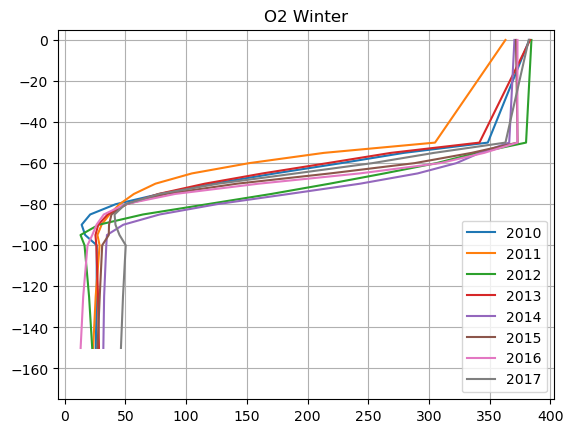

"./resultat/nc/O2/Oxygen_Winter.4Danl.nc"

In [57]:
s = 1
file = joinpath(outputdir, "$(replace(varname,' '=>'_'))_$(seasons[s]).4Danl.nc")
ds = Dataset(file)
ds_name =  ("$(varname)_L2") 
#ds_name = varname
@show ds_name 
#sel = NCDatasets.@select(ds[ds_name], lon == 20.2 && lat == 57.)
#sel = NCDatasets.@select(ds[ds_name], lon == 19.5 && lat == 57.)
sel = NCDatasets.@select(ds[ds_name], Oxygen >)
#sel = NCDatasets.@select(ds[ds_name], lon == 20. && lat == 61.3)
for k=1:length(yearlist)
    toplo = nomissing(sel[:,:,:,k],NaN)
    @show sel[:,:,:,k]
    @show -depthr
    toplot = vec(toplo)
    plot(toplot,-depthr,label=string(yearlist[k]))
end
ylim(-175,5)
legend();
grid("on")
#title("$(yearlist[k][1]):$(yearlist[k][end])")
title("$(savevar) $(seasons[s])")
close(ds)
@show file

In [34]:
using Pkg
Pkg.status()

      Status `C:\Users\a001109\.julia\environments\v1.6\Project.toml`
  [efc8151c] DIVAnd v2.7.7
  [864edb3b] DataStructures v0.18.13
  [7073ff75] IJulia v1.23.3
  [e1d29d7a] Missings v1.1.0
  [85f8d34a] NCDatasets v0.12.14
  [3725be50] PhysOcean v0.6.6
  [d330b81b] PyPlot v2.10.0
  [7243133f] NetCDF_jll v400.702.400+0 ⚲
  [44cfe95a] Pkg
